## LLM: HW2
### Zeinab Sheikhitarghi

In [1]:
%%capture
!pip install transformers datasets tabulate

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from datasets import load_dataset
from tabulate import tabulate
from tqdm.notebook import tqdm
from transformers import BertTokenizer


The goal of this notebook is to implement the model proposed by  Yoon Kim, published in 2014. The original paper can be found [here](https://www.aclweb.org/anthology/D14-1181).
Of course, there exists pytorch and tensorflow implementations on the web. They are more or less correct and efficient. However, here it is important to do it yourself. The goal is to better understand pytorch and the convolution.

The road-map is to:
- Implement the convolution and pooling
- Add dropout on the last layer

To start, it is useful to discover the convolution layers. In this lab, we consider the convolution operation in 1-dimension, followed by the adapted max pooling.


We use the same dataset as before: imdb. The first following cells are very similar to what we did in the HW 1, except that we pool the dataset from the HugginFace hub, using the special `load_dataset` function.


# Data loading


In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


🚧 **Tokenizer** 🚧

Make sure you understand the following code. It is important to understand the tokenization process.

In the next cells we are going to experiment with this object.

In [5]:
print("Type of the tokenizer:", type(tokenizer.vocab))
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)

# Print some keys from the vocabulary
print("Some keys from the vocabulary:", list(tokenizer.vocab.keys())[9000:9010])

Type of the tokenizer: <class 'collections.OrderedDict'>
Length of the vocabulary: 30522
Some keys from the vocabulary: ['screenplay', '##bird', 'contribute', 'indonesian', 'pet', 'creates', '##com', 'enzyme', 'kylie', 'discipline']


In [6]:
def print_sentence(sent):
    """Displays the tokens and respective IDs of a text sample"""
    table = np.array(
        [
            tokenizer.tokenize(sent),
            tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent)),
        ]
    ).T
    print(tabulate(table, headers=["Tokens", "Token IDs"], tablefmt="fancy_grid"))


sample = dataset[19]
print_sentence(sample["review"])
print("The label:", sample["sentiment"])

╒═════════════╤═════════════╕
│ Tokens      │   Token IDs │
╞═════════════╪═════════════╡
│ an          │        2019 │
├─────────────┼─────────────┤
│ awful       │        9643 │
├─────────────┼─────────────┤
│ film        │        2143 │
├─────────────┼─────────────┤
│ !           │         999 │
├─────────────┼─────────────┤
│ it          │        2009 │
├─────────────┼─────────────┤
│ must        │        2442 │
├─────────────┼─────────────┤
│ have        │        2031 │
├─────────────┼─────────────┤
│ been        │        2042 │
├─────────────┼─────────────┤
│ up          │        2039 │
├─────────────┼─────────────┤
│ against     │        2114 │
├─────────────┼─────────────┤
│ some        │        2070 │
├─────────────┼─────────────┤
│ real        │        2613 │
├─────────────┼─────────────┤
│ stink       │       27136 │
├─────────────┼─────────────┤
│ ##ers       │        2545 │
├─────────────┼─────────────┤
│ to          │        2000 │
├─────────────┼─────────────┤
│ be      

In [7]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [8]:
preprocessing_fn(dataset[0], tokenizer)

{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is du

Be sure, you understand this output.

Now we can really prepare the data for the NNet.

🚧 **Data loading** 🚧

Read carefully the data loading process. We want to:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.

Everything is implemented using the `Dataset` class from HuggingFace. It is very convenient and efficient. It is important to understand how it works.

In [9]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

The dataset now outputs list of ids. However, there is one last remaining step. Since we want to have batch of tensors, they should have the same size.

Below is a code for padding batch of lists to the same size.

> 💡 *Note*: This process can be done a bit quicker with HuggingFace built-in `DataCollator` object, that tokenize + pad at once. But since these objects can be a bit complex at first sight, we present here a custom equivalent method. Moreover, they use the same underlying processes than what we present here.

In [10]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

Let's define the `DataLoaders`.

In [11]:
data_collator = DataCollator(tokenizer)

In [12]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

🚧 **Check** 🚧

Let's see what everything does.

Print various information about one batch.

Explore the variables and understand what's inside.

In [13]:
batch = next(iter(train_dataloader))
print("batch is a dictionnary with keys:", batch.keys())
print("Size of different elements:", batch["review_ids"].shape, batch["label"].shape)

batch is a dictionnary with keys: dict_keys(['review_ids', 'label'])
Size of different elements: torch.Size([32, 256]) torch.Size([32, 1])


In [14]:
for i, item in enumerate(train_dataloader):
    if i >= 3:
        break
    print(item['review_ids'].shape)
    print(item['label'].shape)

torch.Size([32, 256])
torch.Size([32, 1])
torch.Size([32, 256])
torch.Size([32, 1])
torch.Size([32, 256])
torch.Size([32, 1])


# Convolution model
Now, we are done with the data and we have our interface for the model, but we need to build the model.
Here the sequence of operation the model will achieve:  
- Embedding
- Convolution (1D)
- Pooling
- Linear

Now the question is: how can do it in pytorch ?


This is easy since most of these operations are already implemented. The  difficult part of the work is dedicated to playing with dimensions. This is true for pytorch, as well as tensorflow. Moreover, things can be tricky if we want our model to work properly with mini-batch (and we want it).
We will go through everything step-by-step.

## Embedding layer

The goal is to store a set of real vectors associated to each symbol (word) in the vocabulary. The layer requires :
- num_embeddings: the vocabulary size or the number of words under consideration. Words are represented by an index (starting at 0)
- embedding_dim : the dimension of the continous space (or the word embeddings.


Implicitely a lookup matrix is created to store *num_embeddings* of *size embedding_dim*. Let start with dummy dimensions that will help us to see what happens.

🚧 **TODO** 🚧

Create an instance of `nn.Embeddings`, with a number of vocabulary equals to `VOCSIZE` and dimension `h1`.

In [15]:
h1 = 50  # dimension of embeddings, the input size for convolution

# TODO
embedding_layer = nn.Embedding(VOCSIZE, h1)

🚧 **TODO** 🚧
- Extract the lookup matrix from the embedding layer and print its shape.

- Print the embeddings sequence of the first 2 sequence of the `batch` created above (it should be totally random!).

- Print the shape of the emebedding sequence of `batch["review_ids"]`.

In [16]:
# TODO
lookup_matrix = embedding_layer.weight

print(lookup_matrix.shape)
print(embedding_layer(batch["review_ids"][:2]).shape)

torch.Size([30522, 50])
torch.Size([2, 256, 50])


## Convolution1D

Look at the documentation of the Conv1d layer. Read it carefully and try to completely understand the following code. A convolution layer expects a tensor as input, with the following dimensions *(B, D, L)*:
- B: size of the batch, the number of examples (here the number of sequence). For the moment we consider *B=1* (only one sequence)
- D: the dimension of the vectors for each time step
- L: the length of the input sequence (the number of tokens in the sequence).

🚧 **Question** 🚧
Is this shape directly compatible with our Embeddings layer defined above?

🚧 **TODO** 🚧

- Make sure the following code computing a convolution run and is consistent.
- Draw what happens to better understand the obtained dimensions.


In [17]:
convolution_layer = nn.Conv1d(in_channels=h1, out_channels=2, kernel_size=3)
sequence_embedding = embedding_layer(batch["review_ids"]) # shape: (batch_size, seq_len, h1)
convolution_output = convolution_layer(sequence_embedding.mT) # shape: (batch_size, h1, seq_len)
# (batch_size, out_channels, new_seq_len = seq_leng − kernel_size + 1)
convolution_output.shape

torch.Size([32, 2, 254])

🚧 **TODO** 🚧

Now if we add another parameter for padding (set to 1). What do you observe ?
Play a bit with the *kernel_size* along with the *padding* to understand the interaction:
- try (kernel_size, padding) = (3, 1)
- (5,1) and (5,2)

In [18]:
def test_conv_layer(padding, kernel_size):
    """
        new_sequence_length= (sequence_length + 2 × padding − kernel_size) + 1
    """
    convolution_layer = nn.Conv1d(
        in_channels=h1,
        out_channels=2,
        kernel_size=kernel_size,
        padding=padding
    )
    convolution_output = convolution_layer(sequence_embedding.mT)
    return convolution_output.shape  # (B, new_seq_len, in_channels)

In [19]:
test_conv_layer(padding=1, kernel_size=3)

torch.Size([32, 2, 256])

In [20]:
test_conv_layer(padding=1, kernel_size=5)

torch.Size([32, 2, 254])

In [21]:
test_conv_layer(padding=2, kernel_size=5)

torch.Size([32, 2, 256])

Here is the code for the `Conv1DClassifier`.
Its modules are:
- A convolutional layer like above.
- An embedding layer like above.
- A non-linearity.
- A pooling layer
- A dropout layer.
- A linear layer that maps the sequence to a scalar.
- A sigmoid output function.

In [22]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The number of padding symbols depends on the kernel size.
        # It is important to ensure that we have always a sequence
        # as long as the kernel size.
        # ex: if ks=3, we add 1 padding before and one after.
        # The sentence "Great" becomes "<pad> Great <pad>"
        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )
        # The parameter for AdaptiveMaxPool1d is the "output size"
        # or the number of output values for a dimension.
        # Here it is one: we want to get the max for every components.
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

Test the classifier on a random sequence.

In [23]:
random_inputs = torch.randint(0, VOCSIZE, (4, 100))
# Test the class: is everything in place:
# A first classifier is built like :
model = Conv1dClassifier(
    vocab_size=VOCSIZE, embedding_dim=25
)  # The parameters of the classifier are randomly initialize, but we
# can use it on a sequence :
out = model(random_inputs)
print(out.shape)  # the output has 2 dimensions
print(out)

# It is correct ? If not, correct the class to get the expected result.

torch.Size([4, 1])
tensor([[0.4312],
        [0.4611],
        [0.7734],
        [0.3796]], grad_fn=<SigmoidBackward0>)


# Training the model

To train the model, we need to define a loss function and an optimizer. For the moment we will rely on an online learning algorithm: online stochastic gradient descent.
- we pick one training example
- compute the loss
- back-propagation of the gradient
- update of the parameters


At the end of one epoch, we evaluate the model on the validation step.

In [24]:
# We redefine the DataLoader, in case you have modified it.
batch_size = 32
train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]
train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)

In [28]:
def compute_accuracy(predictions, labels):
    pred = (predictions > 0.5).int()
    correct = (labels == pred).sum().item()
    return correct


def train_one_epoch(model, dataloader, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.cuda() if torch.cuda.is_available() else v for k, v in batch.items()}
        optimizer.zero_grad()
        probs = model(batch["review_ids"])
        gold = batch["label"]

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


def validate_one_epoch(model, dataloader, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.cuda() if torch.cuda.is_available() else v for k, v in batch.items()}
            probs = model(batch["review_ids"])
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold.float())
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


def plot_training_curves(train_losses, valid_losses, train_accs, valid_accs, n_epochs):
    epochs_range = range(1, n_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, valid_losses, label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Accuracy")
    plt.plot(epochs_range, valid_accs, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [29]:
model = Conv1dClassifier(vocab_size=VOCSIZE, embedding_dim=100, feature_size=100)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

if torch.cuda.is_available():
  model.cuda()

for epoch in range(n_epochs):
    train_avg_loss, train_avg_acc = train_one_epoch(
        model, train_dataloader, optimizer, loss_function
    )
    valid_avg_loss, valid_avg_acc = validate_one_epoch(
        model, valid_dataloader, loss_function
    )

    train_losses.append(train_avg_loss)
    valid_losses.append(valid_avg_loss)
    train_accs.append(train_avg_acc)
    valid_accs.append(valid_avg_acc)

    print(
        f"Epoch {epoch+1}/{n_epochs}\n",
        f"Train Loss: {train_avg_loss:.2f}\n",
        f"Train Acc: {train_avg_acc:.2f}%\n",
        f"Valid Loss: {valid_avg_loss:.2f}\n",
        f"Valid Acc: {valid_avg_acc:.2f}%\n",
    )

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5
 Train Loss: 0.71
 Train Acc: 54.65%
 Valid Loss: 0.65
 Valid Acc: 58.70%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5
 Train Loss: 0.62
 Train Acc: 65.10%
 Valid Loss: 0.57
 Valid Acc: 70.60%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5
 Train Loss: 0.53
 Train Acc: 74.62%
 Valid Loss: 0.51
 Valid Acc: 75.40%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5
 Train Loss: 0.46
 Train Acc: 78.47%
 Valid Loss: 0.47
 Valid Acc: 78.60%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5
 Train Loss: 0.42
 Train Acc: 80.83%
 Valid Loss: 0.44
 Valid Acc: 78.70%



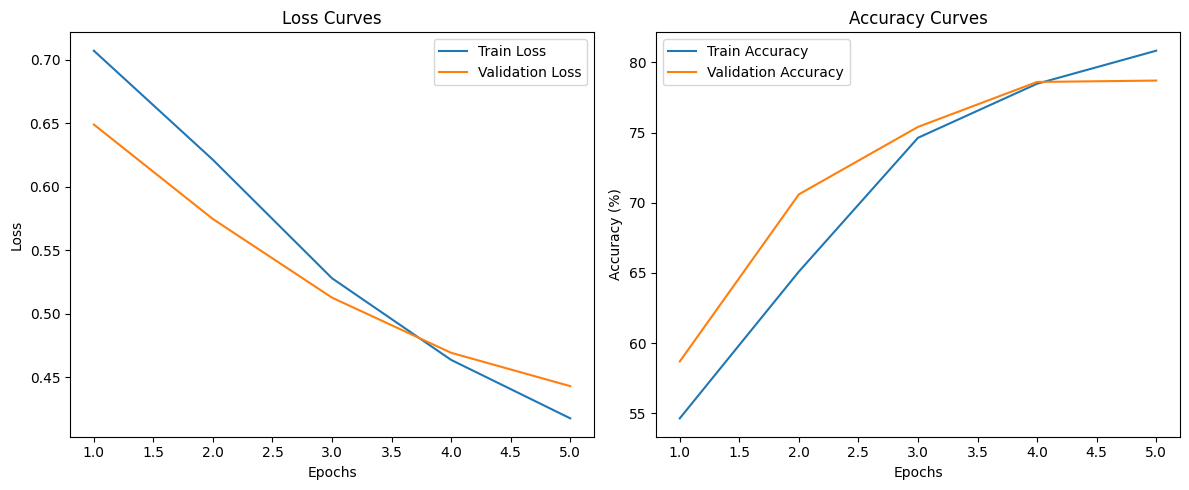

In [30]:
plot_training_curves(train_losses, valid_losses, train_accs, valid_accs, n_epochs)

## Load the Pretrained Word2Vec Embeddings

In [36]:
def load_model(model_path: str):

    if not os.path.exists(model_path):
        raise "The path not found"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    state_dict = torch.load(model_path, map_location=device)
    return state_dict['word_embeddings.weight']

In [34]:
MODEL_PATH = "/content/model_dim-100_radius4_ratio-5-batch-16-epoch-5.ckpt"

In [37]:
word2vec_emb = load_model(MODEL_PATH)

<ipython-input-36-debf69f2f12c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


## Modify the ConvClassifier to use pretrained embeddings

In [38]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated with a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    - pretrained_embeddings: optional tensor for using pretrained word vectors
    - freeze_embeddings: to freeze the predefined embeddings or finue-tune them during training
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3, pretrained_embeddings=None, freeze_embeddings=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size

        if pretrained_embeddings is not None:
            # Use pretrained embeddings and set `requires_grad` based on `freeze_embeddings`
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze_embeddings)
        else:
            # Use nn.Embedding if no pretrained embeddings are provided
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):
        # In PyTorch, convolution expects (B, d, L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B, d, 1)
        hidden_states = hidden_states.squeeze(dim=2)  # (B, d)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

In [40]:
model_with_word2vec = Conv1dClassifier(
    vocab_size=word2vec_emb.shape[0],
    embedding_dim=word2vec_emb.shape[1],
    feature_size=100,
    pretrained_embeddings=word2vec_emb,
    freeze_embeddings=True
)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model_with_word2vec.parameters(), lr=0.0025)
n_epochs = 5
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

if torch.cuda.is_available():
  model_with_word2vec.cuda()


for epoch in range(n_epochs):
    train_avg_loss, train_avg_acc = train_one_epoch(
        model_with_word2vec, train_dataloader, optimizer, loss_function
    )
    valid_avg_loss, valid_avg_acc = validate_one_epoch(
        model_with_word2vec, valid_dataloader, loss_function
    )

    train_losses.append(train_avg_loss)
    valid_losses.append(valid_avg_loss)
    train_accs.append(train_avg_acc)
    valid_accs.append(valid_avg_acc)

    print(
        f"Epoch {epoch+1}/{n_epochs}\n",
        f"Train Loss: {train_avg_loss:.2f}\n",
        f"Train Acc: {train_avg_acc:.2f}%\n",
        f"Valid Loss: {valid_avg_loss:.2f}\n",
        f"Valid Acc: {valid_avg_acc:.2f}%\n",
    )

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5
 Train Loss: 0.82
 Train Acc: 53.75%
 Valid Loss: 0.65
 Valid Acc: 63.40%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5
 Train Loss: 0.66
 Train Acc: 60.65%
 Valid Loss: 0.62
 Valid Acc: 68.80%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5
 Train Loss: 0.63
 Train Acc: 65.30%
 Valid Loss: 0.61
 Valid Acc: 68.60%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5
 Train Loss: 0.59
 Train Acc: 69.78%
 Valid Loss: 0.57
 Valid Acc: 71.40%



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5
 Train Loss: 0.54
 Train Acc: 72.92%
 Valid Loss: 0.54
 Valid Acc: 73.70%



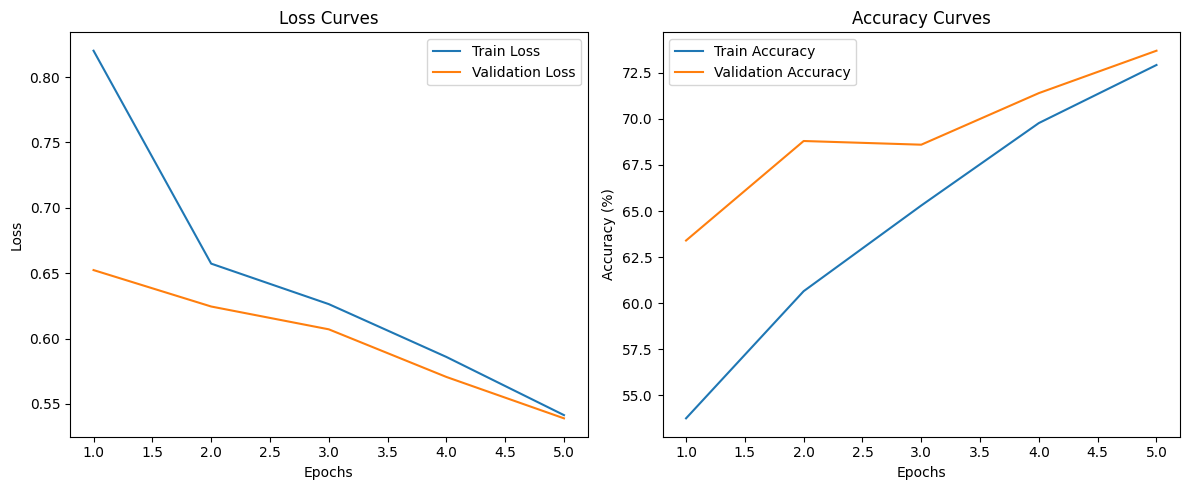

In [41]:
plot_training_curves(train_losses, valid_losses, train_accs, valid_accs, n_epochs)